In [8]:
!pip install pandas matplotlib datetime yfinance numpy scipy scikit-learn pandas_market_calendars numpy pycopula


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as DT
import yfinance as yf
import numpy as np 
import scipy.stats as stats
from sklearn.linear_model import LinearRegression
import pandas_market_calendars as mcal
import datetime
import scipy as sp
import scipy.interpolate
from scipy.stats import norm
import math

import numpy as np
import pandas as pd
from scipy.stats import t, norm
from pycopula.copula import GaussianCopula

In [10]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(1))
    data = data.dropna(subset=['Log Return'])
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)

In [11]:
common_dates = list(set(stoxx50.index).intersection(set(smi.index).intersection(set(sp500.index))))
## losing data on dates, simulation also assuming common dates, losing about 14% data
print("Data Loss:", (3*len(common_dates))/(len(stoxx50)+len(smi)+len(sp500)))

def load_data(file_path):
    data = pd.read_csv(file_path)
    data.index = pd.to_datetime(data['Date'], format='%m/%d/%Y')
    data = data[data.index.isin(common_dates)]
    data['Price'] = data['Price'].str.replace(',', '').astype(float)
    data['Log Return'] = np.log(data['Price'] / data['Price'].shift(-1))
    data.drop(columns=["Change %"], errors = "Ignore", inplace = True)
    data = data.dropna(subset=['Log Return'])
    return data

file_path = "../Data CSV/SMI Historical Data.csv"
smi = load_data(file_path)

file_path = "../Data CSV/S&P 500 Historical Data.csv"
sp500 = load_data(file_path)

file_path = "../Data CSV/Euro Stoxx 50 Historical Data.csv"
stoxx50 = load_data(file_path)


chf = pd.read_csv("../Data CSV/USD_CHF Historical Data.csv")
chf.index = pd.DatetimeIndex(chf["Date"])
eur = pd.read_csv("../Data CSV/USD_EUR Historical Data.csv")
eur.index = pd.DatetimeIndex(eur["Date"])

stoxx50['Price'] = (stoxx50['Price']/eur['Price']).dropna()
stoxx50['Log Return'] = np.log(stoxx50['Price'] / stoxx50['Price'].shift(1))
smi['Price'] = (smi['Price']/chf['Price']).dropna()
smi['Log Return'] = np.log(smi['Price'] / smi['Price'].shift(1))

returns = pd.DataFrame({
    'SMI': smi['Log Return'],
    'STOXX50': stoxx50['Log Return'],
    'SP500': sp500['Log Return']
}).dropna()




Data Loss: 0.8628979857050032


## Simulation using Student T

In [22]:
params_smi = t.fit(returns['SMI'])
params_stoxx50 = t.fit(returns['STOXX50'])
params_sp500 = t.fit(returns['SP500'])

corr_matrix = returns.corr()
chol_matrix = np.linalg.cholesky(corr_matrix)


In [24]:
date = '2024-08-01'
n_simulations = 100
n_timesteps = len(pd.bdate_range(start='2024-08-01',end='2024-12-16'))

z = np.random.normal(size=(n_timesteps, n_simulations, 3))
correlated_z = np.matmul(z, chol_matrix.T)
u = norm.cdf(correlated_z)

sim_smi = t.ppf(u[:, :, 0], *params_smi)
sim_stoxx50 = t.ppf(u[:, :, 1], *params_stoxx50)
sim_sp500 = t.ppf(u[:, :, 2], *params_sp500)

initial_prices = {
    'SMI': smi[smi.index > date]['Price'].iloc[-1],
    'STOXX50': stoxx50[stoxx50.index > date]['Price'].iloc[-1],
    'SP500': sp500[sp500.index > date]['Price'].iloc[-1]
}

price_paths_smi = initial_prices['SMI'] * np.exp(np.cumsum(sim_smi, axis=0))
price_paths_stoxx50 = initial_prices['STOXX50'] * np.exp(np.cumsum(sim_stoxx50, axis=0))
price_paths_sp500 = initial_prices['SP500'] * np.exp(np.cumsum(sim_sp500, axis=0))

price_paths = {
    'SMI': price_paths_smi,
    'STOXX50': price_paths_stoxx50,
    'SP500': price_paths_sp500
}

## Simulation using GBM

In [12]:
np.log(1.03)

np.float64(0.02955880224154443)

In [31]:
dt = 1 / 252  
mu = {}
sigma = {}
risk_free_rate = 0.02879016416943205
for index in ['SMI', 'STOXX50', 'SP500']:
    mean_return = risk_free_rate/252
    variance = returns[index].var()
    mu[index] = mean_return
    sigma[index] = np.sqrt(variance)

corr_matrix = returns.corr()

date = '2024-08-01'
n_simulations = 1000
n_timesteps = len(pd.bdate_range(start='2024-08-01',end='2024-12-16'))

Z = np.random.normal(size=(n_timesteps, n_simulations, 3))
chol_matrix = np.linalg.cholesky(corr_matrix)

Z_flat = Z.reshape(-1, 3)
Z_correlated_flat = Z_flat @ chol_matrix.T
Z_correlated = Z_correlated_flat.reshape(n_timesteps, n_simulations, 3)

initial_prices = {
    'SMI': smi[smi.index > date]['Price'].iloc[-1],
    'STOXX50': stoxx50[stoxx50.index > date]['Price'].iloc[-1],
    'SP500': sp500[sp500.index > date]['Price'].iloc[-1]
}

price_paths = {
    'SMI': np.zeros((n_timesteps + 1, n_simulations)),
    'STOXX50': np.zeros((n_timesteps + 1, n_simulations)),
    'SP500': np.zeros((n_timesteps + 1, n_simulations))
}

for index in ['SMI', 'STOXX50', 'SP500']:
    price_paths[index][0] = initial_prices[index]

for i in range(1, n_timesteps + 1):
    for idx, index in enumerate(['SMI', 'STOXX50', 'SP500']):
        drift_term = (mu[index] - 0.5 * sigma[index] ** 2)
        diffusion_term = sigma[index] * np.sqrt(dt) * Z_correlated[i - 1, :, idx]
        price_paths[index][i] = price_paths[index][i - 1] * np.exp(drift_term + diffusion_term)

for index in ['SMI', 'STOXX50', 'SP500']:
    price_paths[index]= price_paths[index].transpose()

In [32]:
date = '2024-08-01'
final_date = '2024-12-16'

T = (pd.to_datetime(final_date) - pd.to_datetime(date)).days/356
sp500_barrier = 1967.19
sp500_init_level = 3934.38

stoxx_barrier = 1971.31
stoxx_barrier = stoxx_barrier*eur["Price"][date]
stoxx_init_level = 3942.62
stoxx_init_level = stoxx_init_level*eur["Price"][date]
smi_barrier = 5534.15
smi_init_level = 11068.30
smi_barrier = smi_barrier*chf["Price"][date]
smi_init_level = smi_init_level*chf["Price"][date]

l = []
lenth = len(pd.bdate_range(start=date,end=final_date))
for i in range(len(price_paths['SMI'])):
    discount_factor = math.e**(-risk_free_rate*T)
    sim = pd.DataFrame({
        'Date': pd.bdate_range(start=date,end=final_date), 
        'SMI': price_paths['SMI'][i][:lenth], 
        'SP500': price_paths['SP500'][i][:lenth], 
        'STOXX50': price_paths['STOXX50'][i][:lenth]})
    if len(sim[(sim['SMI'] < smi_barrier)]):
        barrier = True
    barrier = False
    if len(sim[(sim['SMI'] < smi_barrier)]) > 0 or len(sim[(sim['SP500'] < sp500_barrier)]) > 0 or len(sim[(sim['STOXX50'] < stoxx_barrier)])>0 :
        barrier = True
    if not barrier:
        l.append(1000*discount_factor)
    else:
        l.append(discount_factor*1000*min(1, sim['SMI'].iloc[-1]/smi_barrier, sim['SP500'].iloc[-1]/sp500_barrier, sim['STOXX50'].iloc[-1]/stoxx_barrier))


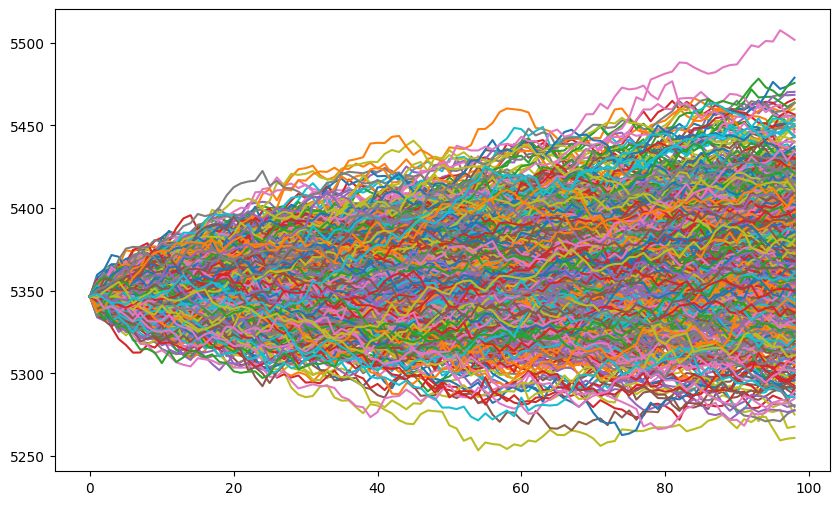

In [38]:
plt.figure(figsize=(10, 6))
for path in price_paths["SP500"]:
    plt.plot(path)
    

In [39]:
np.min(l) - np.max(l)

np.float64(0.0)